In [87]:
# data wrangling and linear algebra
import pandas as pd
import numpy as np
import pandas_ta as ta

# data visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import matplotlib

# metrics
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

# yahoo finance api
import yfinance as yf


# framework
import tensorflow as tf
from tensorflow.keras import layers, models

# misc
import warnings
import os
from tqdm.notebook import tqdm


warnings.filterwarnings(action='ignore')
pd.set_option('display.max_rows',500)
matplotlib.rcParams['figure.figsize']  = (12,8)

In [2]:
# get microsoft stock data
msft = yf.Ticker('MSFT')

# get stock info
msft.info

{'zip': '98052',
 'sector': 'Technology',
 'fullTimeEmployees': 163000,
 'longBusinessSummary': 'Microsoft Corporation develops, licenses, and supports software, services, devices, and solutions worldwide. Its Productivity and Business Processes segment offers Office, Exchange, SharePoint, Microsoft Teams, Office 365 Security and Compliance, and Skype for Business, as well as related Client Access Licenses (CAL); Skype, Outlook.com, and OneDrive; LinkedIn that includes Talent, Learning, Sales, and Marketing solutions, as well as premium subscriptions; and Dynamics 365, a set of cloud-based and on-premises business solutions for small and medium businesses, large organizations, and divisions of enterprises. Its Intelligent Cloud segment licenses SQL and Windows Servers, Visual Studio, System Center, and related CALs; GitHub that provides a collaboration platform and code hosting service for developers; and Azure, a cloud platform. It also offers support services and Microsoft consulting

In [74]:
# get historical market data
hist = msft.history(start = '2010-08-01', end = '2020-07-31', period = '1d')
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-08-02,20.53,20.84,20.34,20.80,55044600,0.0,0
2010-08-03,20.70,20.82,20.52,20.67,56877700,0.0,0
2010-08-04,20.66,20.73,20.10,20.33,78531900,0.0,0
2010-08-05,20.14,20.21,19.92,20.04,64922100,0.0,0
2010-08-06,19.89,20.19,19.77,20.18,55982100,0.0,0
...,...,...,...,...,...,...,...
2020-07-24,200.42,202.86,197.51,201.30,39827000,0.0,0
2020-07-27,201.47,203.97,200.86,203.85,30160900,0.0,0
2020-07-28,203.61,204.70,201.74,202.02,23251400,0.0,0


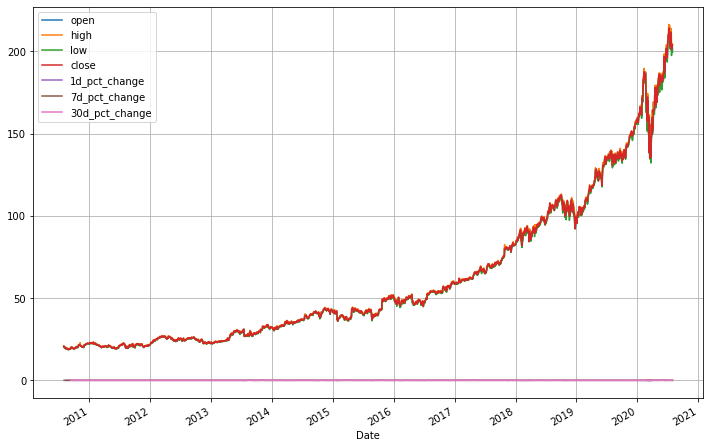

In [32]:
hist.drop(['Volume', 'Dividends', 'Stock Splits'], axis = 1).plot(grid = True )
plt.show()

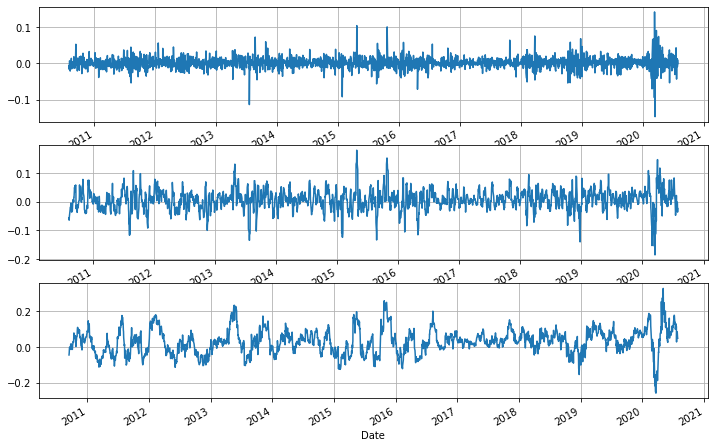

In [5]:
plt.subplot(311)
hist['Close'].pct_change(1).plot(grid = True)

plt.subplot(312)
hist['Close'].pct_change(7).plot(grid = True)

plt.subplot(313)
hist['Close'].pct_change(30).plot(grid = True)

plt.show()

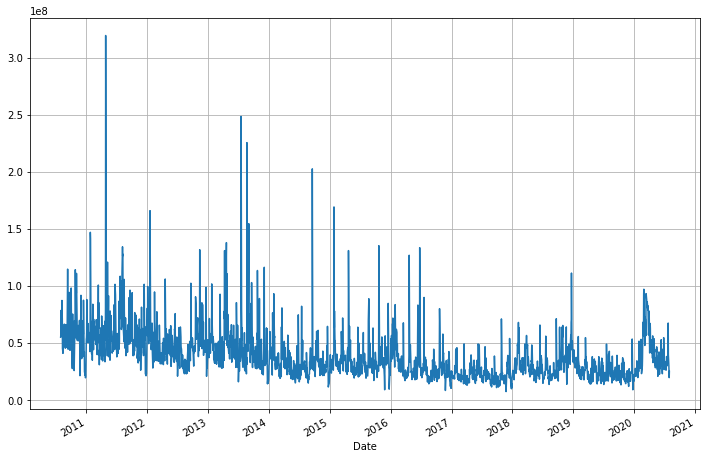

In [6]:
hist['Volume'].plot(grid = True)
plt.show()

<b> Helper Functions

In [7]:
def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b
 
 
def create_Xt_Yt(X, y, percentage=0.95):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test


def get_pct_change(df):    
    df['1d_pct_change'] = df['close'].pct_change()[1:]
    df['7d_pct_change'] = df['close'].pct_change()[7:]
    df['30d_pct_change'] = df['close'].pct_change()[30:]
    return df

def scale_data(d):
    scaled_d = (np.array(d) - np.mean(d))/np.std(d)
    return scaled_d


def get_features(df):    
    
    df = df.drop(['Dividends', 'Stock Splits'], axis = 1)
    
    df.ta.sma(20, append = True)
    df.ta.ema(20, append = True)
    df.ta.rsi(length = 20, append = True)
    df.ta.macd(append = True)
    df.ta.cci(append = True)
    df.ta.bbands(append = True)
    
    return df.dropna().reset_index(drop = True)
    
    

In [33]:
def load_data(df, window, target = '1d_pct_change'):
    df = df.copy()
    
    df.columns = ['open', 'high', 'low', 'close', 'Volume', 'Dividends', 'Stock Splits']
    df = get_pct_change(df)
    df = get_features(df)
    
    print(f'Data contains {df.shape[0]} points and {df.shape[1]} features')
    
    X, y = [], []
        
    target_vals = df[target].values.tolist()
    
    for time in range(len(df)-window):
        
        X_i = []
        y_i = []
        
        for col in df.columns:
            if 'pct_change' not in str(col):
            
                feature = df[col].values.tolist()
            
                f_i = scale_data(feature[time:time+window])
                X_i.append(f_i)                
            
        y_i.append(target_vals[time+window])
        
        x_i = np.column_stack(X_i)
        X.append(x_i)
        y.append(y_i)
        
                            
    X,y = np.array(X), np.array(y)
    
    X_train, X_test, y_train, y_test = create_Xt_Yt(X,y)
    
    print(f'Train/Test input shape: {X_train.shape}/{X_test.shape}\n',
         f'Train/Test target shape: {y_train.shape}/{y_test.shape}')
    
    return X_train, X_test, y_train, y_test                                                    

In [28]:
# params
window = 30
batch_size = 32
epochs = 100

In [36]:
X_train, X_test, y_train, y_test = load_data(df = hist, window = window, target = '1d_pct_change')

Data contains 2487 points and 18 features
Train/Test input shape: (2334, 30, 15)/(123, 30, 15)
 Train/Test target shape: (2334, 1)/(123, 1)


<b> Model Architectures

In [57]:
# create model
model = models.Sequential([
    layers.LSTM(128, input_shape = [None, X_train.shape[-1]], return_sequences = False),
    layers.Dense(100, activation = 'relu'),       
    layers.Dense(100, activation = 'relu'),
    layers.Dense(1)
])

# callbacks
lr_callback = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))


optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum=0.9)
model.compile(loss = 'mae', optimizer = optimizer)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               73728     
_________________________________________________________________
dense_12 (Dense)             (None, 100)               12900     
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 101       
Total params: 96,829
Trainable params: 96,829
Non-trainable params: 0
_________________________________________________________________


In [58]:
history = model.fit(X_train, y_train, batch_size = batch_size, 
                    callbacks = [lr_callback], validation_data = (X_test, y_test), epochs = epochs)

Epoch 1/100
73/73 [==============================] - 2s 31ms/step - loss: 0.0651 - val_loss: 0.0719 - lr: 1.0000e-08
Epoch 2/100
73/73 [==============================] - 1s 17ms/step - loss: 0.0651 - val_loss: 0.0719 - lr: 1.1220e-08
Epoch 3/100
73/73 [==============================] - 1s 18ms/step - loss: 0.0651 - val_loss: 0.0719 - lr: 1.2589e-08
Epoch 4/100
73/73 [==============================] - 1s 14ms/step - loss: 0.0651 - val_loss: 0.0719 - lr: 1.4125e-08
Epoch 5/100
73/73 [==============================] - 1s 11ms/step - loss: 0.0651 - val_loss: 0.0719 - lr: 1.5849e-08
Epoch 6/100
73/73 [==============================] - 1s 12ms/step - loss: 0.0651 - val_loss: 0.0719 - lr: 1.7783e-08
Epoch 7/100
73/73 [==============================] - 1s 12ms/step - loss: 0.0650 - val_loss: 0.0719 - lr: 1.9953e-08
Epoch 8/100
73/73 [==============================] - 1s 14ms/step - loss: 0.0650 - val_loss: 0.0718 - lr: 2.2387e-08
Epoch 9/100
73/73 [==============================] - 1s 11ms/ste

73/73 [==============================] - 1s 11ms/step - loss: 0.0277 - val_loss: 0.0328 - lr: 2.8184e-05
Epoch 71/100
73/73 [==============================] - 1s 12ms/step - loss: 0.0263 - val_loss: 0.0320 - lr: 3.1623e-05
Epoch 72/100
73/73 [==============================] - 1s 14ms/step - loss: 0.0250 - val_loss: 0.0314 - lr: 3.5481e-05
Epoch 73/100
73/73 [==============================] - 1s 14ms/step - loss: 0.0238 - val_loss: 0.0308 - lr: 3.9811e-05
Epoch 74/100
73/73 [==============================] - 1s 14ms/step - loss: 0.0227 - val_loss: 0.0302 - lr: 4.4668e-05
Epoch 75/100
73/73 [==============================] - 1s 14ms/step - loss: 0.0218 - val_loss: 0.0296 - lr: 5.0119e-05
Epoch 76/100
73/73 [==============================] - 1s 11ms/step - loss: 0.0211 - val_loss: 0.0292 - lr: 5.6234e-05
Epoch 77/100
73/73 [==============================] - 1s 14ms/step - loss: 0.0205 - val_loss: 0.0286 - lr: 6.3096e-05
Epoch 78/100
73/73 [==============================] - 1s 13ms/step - 

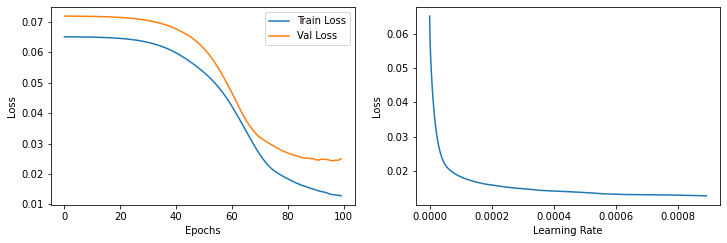

In [59]:
# training loss visualisation
plt.subplot(221)
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

# plotting learning rate vs loss
plt.subplot(222)
plt.plot(history.history['lr'], history.history['loss'])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')

plt.show()

In [60]:
prediction = model.predict(X_test)
prediction.shape

(123, 1)

In [115]:
# creating forecast

def get_forecast(model, df, path = ""):
    forecast = []
    df.columns = ['open', 'high', 'low', 'close', 'Volume', 'Dividends', 'Stock Splits']
    df = get_pct_change(df)
    df = get_features(df)
    
    if os.path.exists(path):
        model = models.load_model(path)
    else:
        pass
    
    tk0 = tqdm(range(len(df) - window), total = len(df)-window)
    for time in tk0:
        
        X_i = []
        
        
        for col in df.columns:
            if 'pct_change' not in str(col):
            
                feature = df[col].values.tolist()
            
                f_i = scale_data(feature[time:time+window])
                X_i.append(f_i)                
            
        
        x_i = np.column_stack(X_i)
        forecast.append(model.predict(x_i[np.newaxis]))
        
    return forecast
        

In [116]:
forecast = get_forecast(model, hist)
len(forecast)

2457